In [271]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from numpy.linalg import svd, norm
import scipy
import pickle
import os 
import re

import torch

import scienceplots
plt.style.use('science')
plt.style.use(['no-latex'])

import net_helpers
import mpn_tasks
import helper
import mpn
import clustering

c_vals = ['#e53e3e', '#3182ce', '#38a169', '#805ad5','#dd6b20', '#319795', '#718096', '#d53f8c', '#d69e2e',] * 10

In [272]:
basepath = "./pretraining"
stage1_name1 = "fdanti" # compare the stimulus period
stage1_name2 = "delaygo" # compare the response period
final_name = "delayanti"

seed = 361
chosen_network = "vanilla"
N = 200
withL2 = "+L2"
batch_size = 128
metric = "stimulus"

checkname = f"{stage1_name1}_{stage1_name2}_{chosen_network}_seed{seed}_+hidden{N}+batch{batch_size}+{metric}{withL2}"

filepath = f"output_{checkname}"
parampath = f"param_{checkname}"

stage1_output_path = f"{basepath}/{filepath}_stage1.npz"
stage2_output_path = f"{basepath}/{filepath}_stage2.npz"
final_param_path = f"{basepath}/{parampath}_result.npz"

stage1_output = np.load(stage1_output_path, allow_pickle=True)
stage2_output = np.load(stage2_output_path, allow_pickle=True)
final_param = np.load(final_param_path, allow_pickle=True)

pretraining/loss_fdanti_delaygo_vanilla_seed361_+hidden200+batch128+stimulus+L2.png


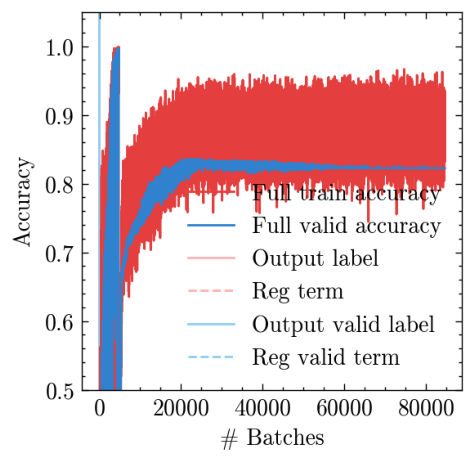

In [273]:
from pathlib import Path
from PIL import Image

def find_pngs_with_components(root, components, recursive=True, case_sensitive=False):
    """
    Return a list of Paths to .png files whose *filenames* contain all substrings in `components`.
    """
    root = Path(root)
    if not case_sensitive:
        components = [c.lower() for c in components]

    candidates = root.rglob("*.png") if recursive else root.glob("*.png")
    matches = []
    for p in candidates:
        name = p.name if case_sensitive else p.name.lower()
        if all(c in name for c in components):
            matches.append(p)

    matches.sort(key=lambda p: p.stat().st_mtime, reverse=True)
    return matches

def show_image(path, size=(6,6)):
    img = Image.open(path)
    fig, ax = plt.subplots(1,1,figsize=size)
    ax.imshow(img)
    ax.axis('off')
    fig.show()

search_root = "./pretraining/"

components_loss = ["loss", f"seed{seed}"]    
matches_loss = find_pngs_with_components(search_root, components_loss,
                                    recursive=True, case_sensitive=False)
print(matches_loss[0])
show_image(matches_loss[0])

stop: 4700


Text(0, 0.5, 'Validation Accuracy')

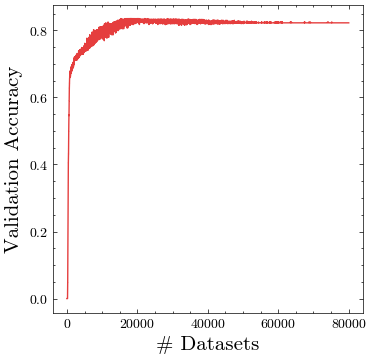

In [274]:
# 2025-11-17: truncate and normalize only for the post-training validation accuracy
fig, ax = plt.subplots(1,1,figsize=(4,4))
stop = final_param["pretrain_stop"]
print(f"stop: {stop}")
acc_iter = final_param["valid_acc_iter"]
acc = final_param["valid_acc"]
post_mask = acc_iter > stop + 1
acc_iter, acc = acc_iter[post_mask] - stop, acc[post_mask]
ax.plot(acc_iter, acc, c=c_vals[0])
ax.set_xlabel("# Datasets", fontsize=15)
ax.set_ylabel("Validation Accuracy", fontsize=15)

pretraining/lowD_fdanti_delaygo_vanilla_seed361_+hidden200+batch128+stimulus+L2_stage2.png


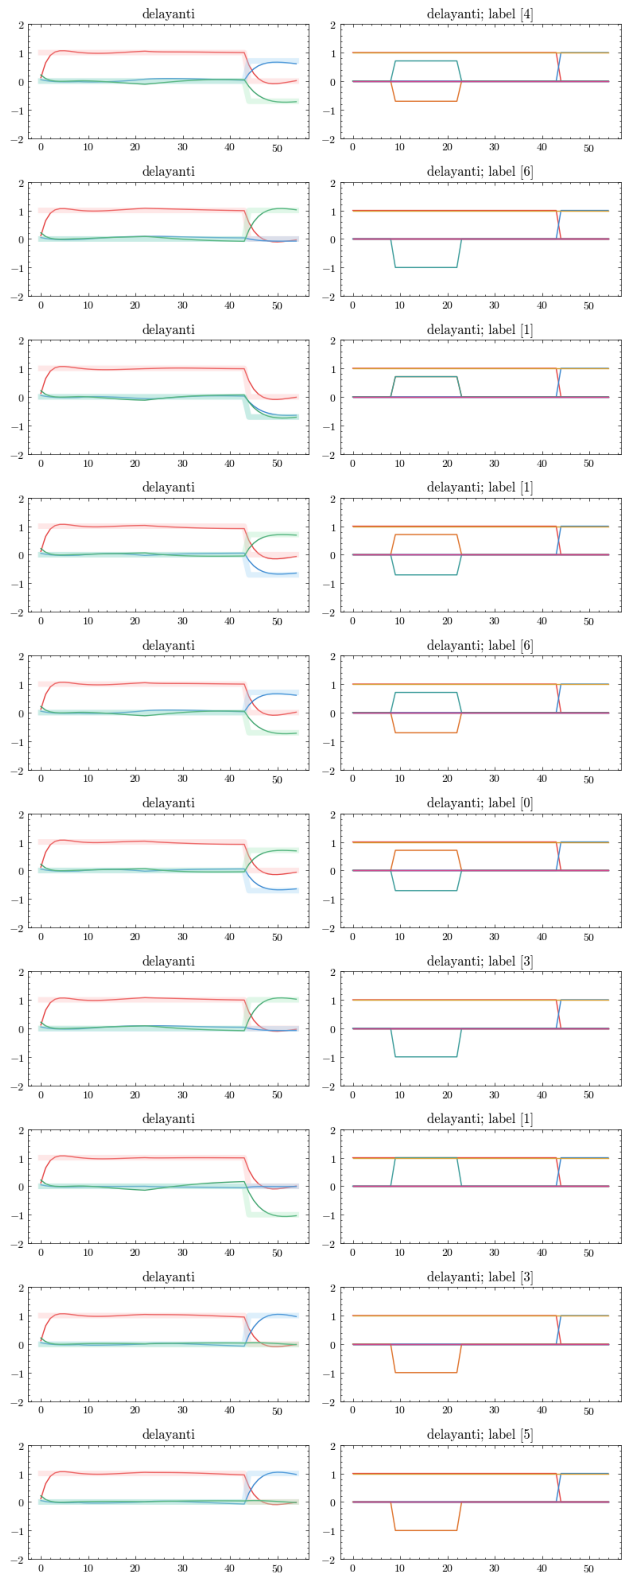

In [275]:
components_showcase2 = ["lowD", f"seed{seed}", "stage2"]    
matches_showcase2 = find_pngs_with_components(search_root, components_showcase2,
                                    recursive=True, case_sensitive=False)
print(matches_showcase2[0])
show_image(matches_showcase2[0], size=(4*2,4*20))

pretraining/lowD_fdanti_delaygo_vanilla_seed361_+hidden200+batch128+stimulus+L2_stage1.png


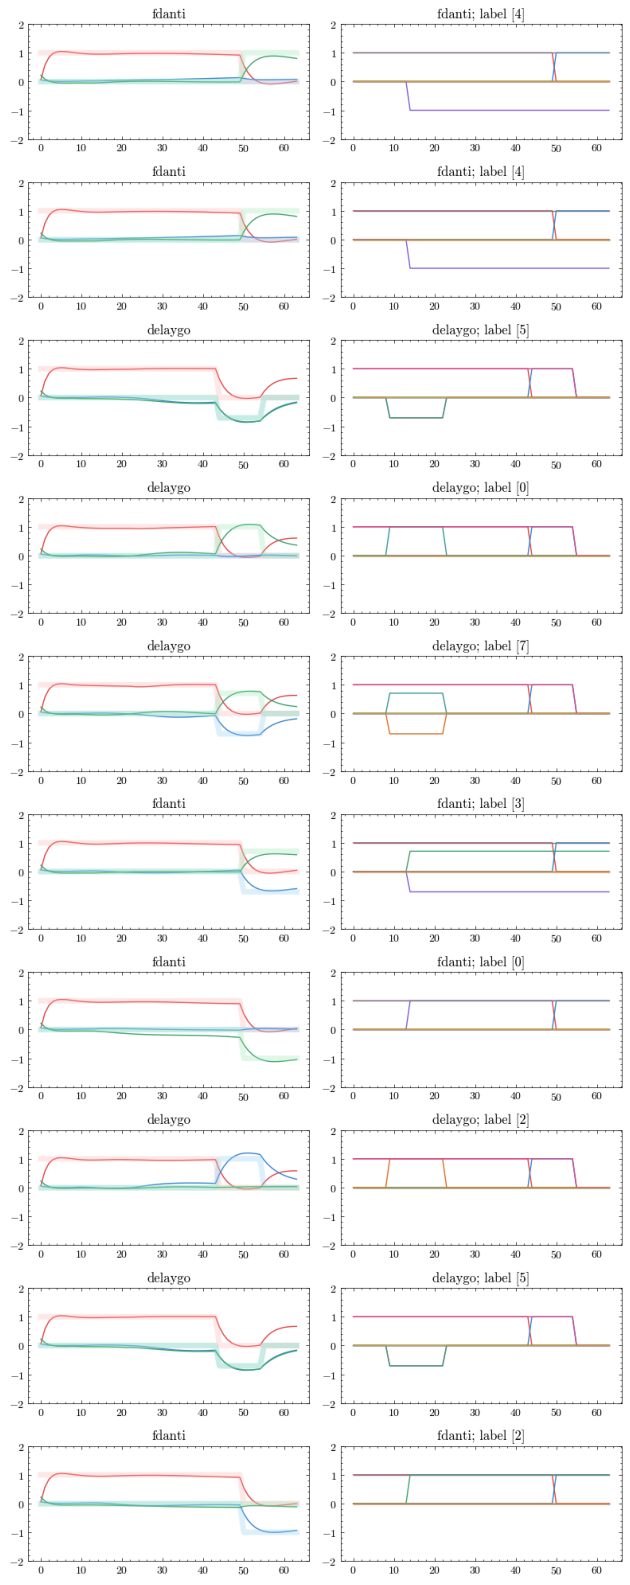

In [276]:
components_showcase1 = ["lowD", f"seed{seed}", "stage1"]    
matches_showcase1 = find_pngs_with_components(search_root, components_showcase1,
                                    recursive=True, case_sensitive=False)
print(matches_showcase1[0])
show_image(matches_showcase1[0], size=(4*2,4*20))

In [277]:
all_rule_info = final_param['rules_epochs']

In [278]:
final_param.files

['rules_epochs',
 'rules_epochs2',
 'hyp_dict_old',
 'hyp_dict',
 'all_rules',
 'Ms_orig_stage1',
 'hs_stage1',
 'bs_stage1',
 'xs_stage1',
 'Ms_orig_stage2',
 'hs_stage2',
 'bs_stage2',
 'xs_stage2',
 'pretrain_stop',
 'valid_acc_iter',
 'valid_acc']

In [279]:
stage1_output.files

['test_input_np',
 'net_out_stage1_final',
 'test_output_np',
 'rules_epochs',
 'task_params',
 'test_task']

In [280]:
stage2_output.files

['test_input_np',
 'net_out_final',
 'test_output_np',
 'rules_epochs2',
 'task_params',
 'test_task']

In [281]:
len(stage2_output["test_task"])

50

In [282]:
test_task = stage1_output["test_task"]
stage1_op = final_param["hs_stage1"]
stage1_m_op = final_param["Ms_orig_stage1"]
stage2_op = final_param["hs_stage2"]
stage2_m_op = final_param["Ms_orig_stage2"]

stage1_rules_epochs = stage1_output["rules_epochs"].item()
stage2_rules_epochs = stage2_output["rules_epochs2"].item()

print(f"stage1_rules_epochs: {stage1_rules_epochs}")
print(f"stage2_rules_epochs: {stage2_rules_epochs}")
print(f"stage2_op: {stage2_op.shape}")
print(f"stage2_m_op: {stage2_m_op.shape}")

stage1_rules_epochs: {'fdanti': {'fix1': (None, 14), 'stim1': (14, 50), 'go1': (50, 64)}, 'delaygo': {'fix1': (None, 9), 'stim1': (9, 23), 'delay1': (23, 44), 'go1': (44, 55)}}
stage2_rules_epochs: {'delayanti': {'fix1': (None, 9), 'stim1': (9, 23), 'delay1': (23, 44), 'go1': (44, 55)}}
stage2_op: (50, 55, 200)
stage2_m_op: ()


In [283]:
def period_slice(op, epochs, name, key, *, shift_percentage=0, mask=None):
    """Return op restricted to [start+shift:end] along time, with optional boolean mask on trials."""
    start, end = epochs[name][key]
    shift = int((end - start) * shift_percentage)
    print(shift)
    if mask is not None:
        op = op[mask, :, :]
    return op[:, start + shift:end, :]

period_shift_percentage = 1/4

# trial masks for stage 1
mask0 = (test_task == 0)
mask1 = (test_task == 1)

# ---- stimulus period ----
test_task_0_stim     = period_slice(stage1_op,   stage1_rules_epochs, stage1_name1, "stim1", mask=mask0)
test_task_final_stim = period_slice(stage2_op,   stage2_rules_epochs, final_name,   "stim1")

if chosen_network == "dmpn": 
    # modulation counterparts (stim)
    test_task_0_stim_m     = period_slice(stage1_m_op, stage1_rules_epochs, stage1_name1, "stim1", mask=mask0)
    test_task_final_stim_m = period_slice(stage2_m_op, stage2_rules_epochs, final_name,   "stim1")

# ---- go period ----
test_task_1_go     = period_slice(stage1_op,   stage1_rules_epochs, stage1_name2, "go1", 
                                  shift_percentage=period_shift_percentage, mask=mask1)
test_task_final_go = period_slice(stage2_op,   stage2_rules_epochs, final_name,   "go1", 
                                  shift_percentage=period_shift_percentage)

if chosen_network == "dmpn": 
    # modulation counterparts (go)
    test_task_1_go_m     = period_slice(stage1_m_op, stage1_rules_epochs, stage1_name2, "go1", 
                                        shift_percentage=period_shift_percentage, mask=mask1)
    test_task_final_go_m = period_slice(stage2_m_op, stage2_rules_epochs, final_name,   "go1", 
                                        shift_percentage=period_shift_percentage)

assert test_task_0_stim.shape[-1] == test_task_final_stim.shape[-1] == N
assert test_task_1_go.shape[-1] == test_task_final_go.shape[-1] == N

print(test_task_0_stim.shape, test_task_final_stim.shape)
print(test_task_1_go.shape, test_task_final_go.shape)

if chosen_network == "dmpn": 
    print(test_task_0_stim_m.shape, test_task_final_stim_m.shape)
    print(test_task_1_go_m.shape, test_task_final_go_m.shape)

0
0
2
2
(50, 36, 200) (50, 14, 200)
(50, 9, 200) (50, 9, 200)


In [284]:
def _participation_ratio(cov_mat):
    """
    cov_mat: (d, d) symmetric PSD covariance matrix
    returns scalar PR
    """
    eigvals = np.linalg.eigvalsh(cov_mat)  # sorted ascending, all real
    # numerical safety: clip tiny negatives to 0
    eigvals = np.clip(eigvals, 0, None)
    s1 = np.sum(eigvals)
    s2 = np.sum(eigvals ** 2)
    if s1 == 0 or s2 == 0:
        return 0.0
    return (s1 ** 2) / s2

def pca_cross_variance_featurewise(
    X, Y, n_components=None, plot=True, center_on="X", 
    X_up=20, name="", datatype="hidden"
):
    """
    PCA on features (last axis) of X; project Y onto X's PCs.
    center_on: "X" (default) subtract X's mean from Y; or "Y" subtract Y's mean.
    Returns:
        evr_X, cev_X,
        evr_Y_using_X, cev_Y_using_X,
        pca,
        PR_X, PR_Y, PR_Y_in_Xbasis   ### NEW
    2025-10-27: to match L's paper Figure 6, X is post-training and Y is pre-training 
    """

    # ----- reshape to 2D: (num_samples, num_features) -----
    if datatype == "hidden": 
        X2d = X.reshape(-1, X.shape[-1])
        Y2d = Y.reshape(-1, Y.shape[-1])

    elif datatype == "modulation": 
        # current design: modulation matrix is square
        assert X.shape[-1] == X.shape[-2]
        X2d = X.reshape(-1, X.shape[-1] * X.shape[-2])
        Y2d = Y.reshape(-1, Y.shape[-1] * Y.shape[-2])

    elif datatype == "modulation_post": 
        assert X.shape[-1] == X.shape[-2]
        X2d = X.reshape(-1, X.shape[-1])
        Y2d = Y.reshape(-1, Y.shape[-1])

    elif datatype == "modulation_pre": 
        X2d = np.swapaxes(X, -1, -2).reshape(-1, X.shape[-2])
        Y2d = np.swapaxes(Y, -1, -2).reshape(-1, Y.shape[-2])

    else:
        raise TypeError("datatype not valid")

    # sanity: same feature dimension
    assert X2d.shape[1] == Y2d.shape[1], \
        "X and Y must share the same feature dimension (last axis)."

    # ----- PCA on X -----
    pca = PCA(n_components=n_components)
    pca.fit(X2d)

    evr_X = pca.explained_variance_ratio_
    cev_X = np.cumsum(evr_X)

    # ----- center Y according to choice -----
    if center_on == "X":
        Y_centered = Y2d - pca.mean_
    elif center_on == "Y":
        Y_centered = Y2d - Y2d.mean(axis=0, keepdims=True)
    else:
        raise ValueError('center_on must be "X" or "Y"')

    # ----- project Y into X PCs -----
    Y_proj = Y_centered @ pca.components_.T  # (num_samples, n_components_used)

    # ----- variance explained in Y by each X PC -----
    var_total_Y = np.var(Y_centered, axis=0, ddof=0).sum()
    if var_total_Y == 0:
        evr_Y_using_X = np.zeros(pca.components_.shape[0])
    else:
        var_per_pc_Y = np.var(Y_proj, axis=0, ddof=0)
        evr_Y_using_X = var_per_pc_Y / var_total_Y
    cev_Y_using_X = np.cumsum(evr_Y_using_X)

    # calculate participation ratio
    # not doing for [modulation], for which the covariance matrix will be N^2 * N^2
    if not datatype == "modulation": 
        X_centered = X2d - X2d.mean(axis=0, keepdims=True)
        cov_X = (X_centered.T @ X_centered) / X_centered.shape[0]  # ddof=0
        PR_X = _participation_ratio(cov_X)
    
        # PR_Y: based on covariance of Y2d (centered same way as for PR_Y,
        # we should center Y with its OWN mean; participation ratio is an
        # intrinsic property of Y, not relative to X)
        Y_intrinsic_centered = Y2d - Y2d.mean(axis=0, keepdims=True)
        cov_Y = (Y_intrinsic_centered.T @ Y_intrinsic_centered) / Y_intrinsic_centered.shape[0]
        PR_Y = _participation_ratio(cov_Y)
    
        # PR_Y_in_Xbasis: effective dimensionality
        # of Y in the subspace defined by X's PCs.
        # Use covariance of Y_proj (which is Y centered as specified above).
        cov_Yproj = (Y_proj.T @ Y_proj) / Y_proj.shape[0]
        PR_Y_in_Xbasis = _participation_ratio(cov_Yproj)
    else:
        PR_X, PR_Y, PR_Y_in_Xbasis = np.nan, np.nan, np.nan

    if plot:
        xs = np.arange(1, len(evr_X) + 1)

        fig, ax = plt.subplots(1, 3, figsize=(5*3, 3))

        ax[0].plot(xs, evr_X, marker='o', label='X (fit)')
        ax[0].plot(xs, evr_Y_using_X, marker='o', label='Y (using X PCs)')
        ax[0].set_xlabel('# PCs')
        ax[0].set_ylabel('Variance Explained (per PC)')
        ax[0].set_title('Scree Plot (Feature-wise PCA)')
        ax[0].set_xlim(0, X_up)
        ax[0].legend()

        ax[1].plot(xs, cev_X, marker='o', label='X (fit)')
        ax[1].plot(xs, cev_Y_using_X, marker='o', label='Y (using X PCs)')
        ax[1].set_xlabel('# PCs')
        ax[1].set_ylabel('Cumulative Variance Explained')
        ax[1].set_title('Cumulative Variance Explained')
        ax[1].set_xlim(0, X_up)
        ax[1].set_ylim(0, 1.05)
        ax[1].legend()

        ax[2].bar(
            ["PR_X", "PR_Y", "PR_Y|Xbasis"],
            [PR_X, PR_Y, PR_Y_in_Xbasis]
        )
        ax[2].set_ylabel('Participation Ratio (eff. dim)')
        ax[2].set_title('Effective Dimensionality')

        fig.tight_layout()
        fig.savefig(f"./pretraining_analysis/{name}_{datatype}_pca.png")

    return (
        evr_X,
        cev_X,
        evr_Y_using_X,
        cev_Y_using_X,
        pca,
        [PR_X,
        PR_Y,
        PR_Y_in_Xbasis],
    )


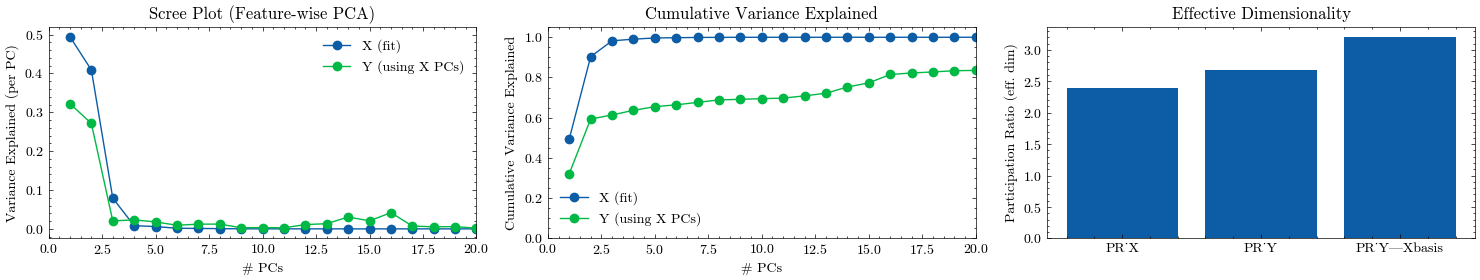

In [285]:
_, cev_X_h_stim, _, cev_Yx_h_stim, pca, PR_h_stim = pca_cross_variance_featurewise(test_task_final_stim, test_task_0_stim, 
                                                                                   n_components=N, plot=True, center_on="X", 
                                                                                   X_up=20, name=f"{checkname}_{chosen_network}_stimulus", 
                                                                                   datatype="hidden")

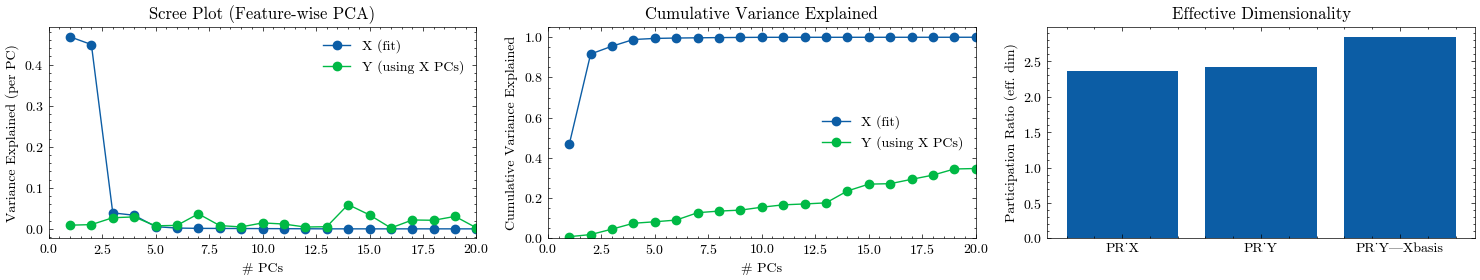

In [286]:
_, cev_X_h_resp, _, cev_Yx_h_resp, pca, PR_h_resp = pca_cross_variance_featurewise(test_task_final_go, test_task_1_go, 
                                                                                   n_components=N, plot=True, center_on="X", 
                                                                                   X_up=20, name=f"{checkname}_{chosen_network}_response", 
                                                                                   datatype="hidden")

In [287]:
if chosen_network == "dmpn": 
    _, cev_X_m_stim, _, cev_Yx_m_stim, pca, PR_m_stim = pca_cross_variance_featurewise(test_task_final_stim_m, test_task_0_stim_m, 
                                                                                       n_components=N, plot=True, center_on="X", 
                                                                                       X_up=20**2, name=f"{checkname}_{chosen_network}_stimulus", 
                                                                                       datatype="modulation")

In [288]:
if chosen_network == "dmpn": 
    _, cev_X_m_resp, _, cev_Yx_m_resp, pca, PR_m_resp = pca_cross_variance_featurewise(test_task_final_go_m, test_task_1_go_m, 
                                                                                       n_components=N, plot=True, center_on="X", 
                                                                                       X_up=20**2, name=f"{checkname}_{chosen_network}response", 
                                                                                       datatype="modulation")

In [289]:
if chosen_network == "dmpn": 
    _, cev_X_m_stim_pre, _, cev_Yx_m_stim_pre, pca, PR_m_stim_pre = pca_cross_variance_featurewise(test_task_final_stim_m, test_task_0_stim_m, 
                                                                                                   n_components=N, plot=True, center_on="X", 
                                                                                                   X_up=20, name=f"{checkname}_{chosen_network}_stimulus", 
                                                                                                   datatype="modulation_pre")

In [290]:
if chosen_network == "dmpn": 
    _, cev_X_m_resp_pre, _, cev_Yx_m_resp_pre, pca, PR_m_resp_pre = pca_cross_variance_featurewise(test_task_final_go_m, test_task_1_go_m, 
                                                                                                   n_components=N, plot=True, center_on="X", 
                                                                                                   X_up=20, name=f"{checkname}_{chosen_network}_response", 
                                                                                                   datatype="modulation_pre")

In [291]:
if chosen_network == "dmpn": 
    _, cev_X_m_stim_post, _, cev_Yx_m_stim_post, pca, PR_m_stim_post = pca_cross_variance_featurewise(test_task_final_stim_m, test_task_0_stim_m, 
                                                                                                      n_components=N, plot=True, center_on="X", 
                                                                                                      X_up=20, name=f"{checkname}_{chosen_network}_stimulus", 
                                                                                                      datatype="modulation_post")

In [292]:
if chosen_network == "dmpn": 
    _, cev_X_m_resp_post, _, cev_Yx_m_resp_post, pca, PR_m_resp_post = pca_cross_variance_featurewise(test_task_final_go_m, test_task_1_go_m, 
                                                                                                      n_components=N, plot=True, center_on="X", 
                                                                                                      X_up=20, name=f"{checkname}_{chosen_network}_response", 
                                                                                                      datatype="modulation_post")

In [293]:
if chosen_network == "dmpn": 
    all_result = {
        "hidden": {
            "stimulus": [cev_X_h_stim, cev_Yx_h_stim], 
            "response": [cev_X_h_resp, cev_Yx_h_resp]
        }, 
        "modulation": {
            "stimulus": [cev_X_m_stim, cev_Yx_m_stim], 
            "response": [cev_X_m_resp, cev_Yx_m_resp]
        },
        "modulation_pre": {
            "stimulus": [cev_X_m_stim_pre, cev_Yx_m_stim_pre], 
            "response": [cev_X_m_resp_pre, cev_Yx_m_resp_pre]
        },
        "modulation_post": {
            "stimulus": [cev_X_m_stim_post, cev_Yx_m_stim_post], 
            "response": [cev_X_m_resp_post, cev_Yx_m_resp_post]
        }, 
        "learning": {
            "acc_iter": acc_iter, 
            "acc": acc
        }
    }
elif chosen_network == "vanilla":
    all_result = {
        "hidden": {
            "stimulus": [cev_X_h_stim, cev_Yx_h_stim], 
            "response": [cev_X_h_resp, cev_Yx_h_resp]
        }, 
        "learning": {
            "acc_iter": acc_iter, 
            "acc": acc
        }
    }

final_result = f"./pretraining_analysis/{checkname}_{chosen_network}_stage1.pkl"

with open(final_result, "wb") as f:
    pickle.dump(all_result, f)

In [294]:
def find_pkl_files_with_string(root_dir, keyword):
    """
    """
    matched_files = []
    for dirpath, _, filenames in os.walk(root_dir):
        for name in filenames:
            if name.endswith('.pkl') and keyword in name:
                matched_files.append(os.path.join(dirpath, name))
    return matched_files

task1, task2 = stage1_name1, stage1_name2
matches = find_pkl_files_with_string("./pretraining_analysis/", f"{task1}_{task2}")
match_find = [re.search(r"seed(\d+)", path) for path in matches]
seeds = [int(match.group(1)) for match in match_find]
hiddens = [int(re.search(r'\+hidden(\d+)', path).group(1)) for path in matches]

In [295]:
matches

['./pretraining_analysis/fdanti_delaygo_vanilla_seed222_+hidden200+batch128+stimulus+L2_vanilla_stage1.pkl',
 './pretraining_analysis/fdanti_delaygo_vanilla_seed182_+hidden200+batch128+stimulus+L2_vanilla_stage1.pkl',
 './pretraining_analysis/fdanti_delaygo_vanilla_seed361_+hidden200+batch128+stimulus+L2_vanilla_stage1.pkl']

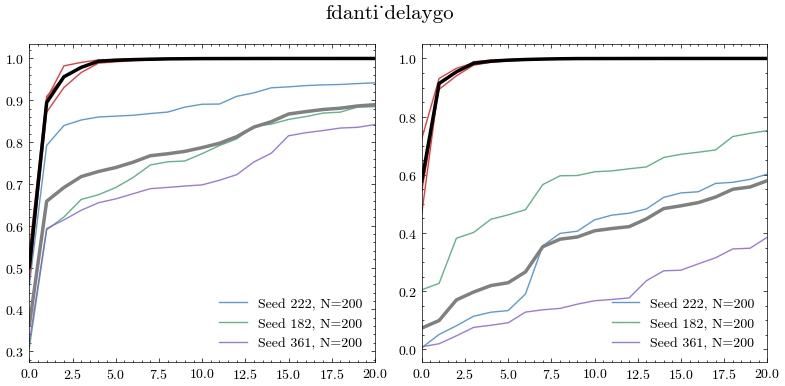

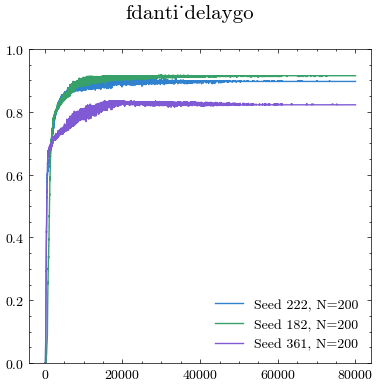

In [296]:
# plot results across different trials
if chosen_network == "dmpn": 
    fig, ax = plt.subplots(4,2,figsize=(4*2,4*4))
    names = [["hidden", "stimulus"], ["hidden", "response"],["modulation", "stimulus"], ["modulation", "response"],
            ["modulation_pre", "stimulus"], ["modulation_pre", "response"], ["modulation_post", "stimulus"], ["modulation_post", "response"]]
    
elif chosen_network == "vanilla": 
    fig, ax = plt.subplots(1,2,figsize=(4*2,4*1), squeeze=False)
    names = [["hidden", "stimulus"], ["hidden", "response"]]

figacc, axacc = plt.subplots(1,1,figsize=(4,4))

# Prepare storage for mean curves
num_subplots = len(names)
all_X = [ [] for _ in range(num_subplots) ]
all_Y = [ [] for _ in range(num_subplots) ]

for match_file_index, match_file in enumerate(matches):
    with open(match_file, "rb") as file:
        data = pickle.load(file)

    for i in range(num_subplots):
        X = data[names[i][0]][names[i][1]][0]
        Y = data[names[i][0]][names[i][1]][1]

        all_X[i].append(X)
        all_Y[i].append(Y)

        ax[i//2, i%2].plot(X, color=c_vals[0])
        ax[i//2, i%2].plot(
            Y,
            color=c_vals[1 + match_file_index],
            alpha=0.8,
            label=f"Seed {seeds[match_file_index]}, N={hiddens[match_file_index]}"
        )
        ax[i//2, i%2].set_xlim([0, 20])

    # plot validation accuracy
    acc_iter, acc = data["learning"]["acc_iter"], data["learning"]["acc"]
    axacc.plot(acc_iter, acc, color=c_vals[1+match_file_index], label=f"Seed {seeds[match_file_index]}, N={hiddens[match_file_index]}")

for i in range(num_subplots):
    mean_X = np.mean(np.vstack(all_X[i]), axis=0)
    mean_Y = np.mean(np.vstack(all_Y[i]), axis=0)

    ax[i//2, i%2].plot(mean_X, color="black", linewidth=2.5)
    ax[i//2, i%2].plot(mean_Y, color="gray", linewidth=2.5)

for i in range(num_subplots):
    ax[i//2, i%2].legend()

fig.suptitle(f"{task1}_{task2}", fontsize=15)
fig.tight_layout()
fig.savefig(f"./pretraining_analysis/{task1}_{task2}_analysis.png", dpi=300)

axacc.legend()
axacc.set_ylim([0, 1])
figacc.suptitle(f"{task1}_{task2}", fontsize=15)
figacc.tight_layout()
figacc.savefig(f"./pretraining_analysis/{task1}_{task2}_acc_analysis.png", dpi=300)